In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import tarfile
import pathlib
import PIL.Image

In [2]:
tf.get_logger().setLevel("ERROR")

In [3]:
DATASETS_DIR = "data"
DATASETS_TGZ = "datasets.tgz"
UNPACKED_DIR = os.path.join("data", "unpacked")

In [4]:
os.makedirs(UNPACKED_DIR, exist_ok=True)
tgz_path = os.path.join(DATASETS_DIR, DATASETS_TGZ)
dataset_tgz = tarfile.open(tgz_path)
dataset_tgz.extractall(path=UNPACKED_DIR)
dataset_tgz.close()

In [5]:
def read_csv_dataset(name, path=UNPACKED_DIR):
    csv_path = os.path.join(path, name + ".csv")
    return pd.read_csv(csv_path)

titanic_ds = read_csv_dataset("Titanic")
diamonds_ds = read_csv_dataset("diamonds")

In [6]:
def read_images_dataset(name, path=UNPACKED_DIR, image_size=32, train_split=0.75, val_split=0.15):
    test_split = 1 - train_split - val_split
    train_ds, val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, name),
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        image_size=(image_size, image_size),
        batch_size=32,
        seed=42,
        shuffle=True,
        validation_split=val_split + test_split,
        subset="both"
    )
    classes = train_ds.class_names
    train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    val_test_ds = val_test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
    train_ds = train_ds.map(lambda x, y: (rescale(x), y))
    val_test_ds = val_test_ds.map(lambda x, y: (rescale(x), y))
    
    size = len(val_test_ds)
    val_ds = val_test_ds.take(int(size * (val_split / (val_split + test_split))))
    test_ds = val_test_ds.skip(int(size * (val_split / (val_split + test_split))))
    
    return train_ds, val_ds, test_ds, classes

image_size = 256
weather_ds = read_images_dataset("weather-image", image_size=image_size)

Found 6862 files belonging to 11 classes.
Using 5147 files for training.
Using 1715 files for validation.


## From Biological to Artificial Neurons

#### The Perceptron

In [7]:
from sklearn.linear_model import Perceptron

titanic_ds.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [8]:
titanic_ds["Sex"] = (titanic_ds["Sex"] == "male").astype(np.int32)
X, y = titanic_ds[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]], titanic_ds["Survived"]
X_train, X_test = X.iloc[5:], X.iloc[:5]
y_train, y_test = y.iloc[5:], y.iloc[:5]

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

per_clf = Perceptron(random_state=42, n_iter_no_change=100)
per_clf.fit(X_train, y_train)

y_pred = per_clf.predict(X_test)
y_pred

array([0, 1, 1, 1, 0], dtype=int64)

In [10]:
y_test

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## Implementing MLPs with Keras

#### Building an Image Classifier Using the Sequential API

##### Using Keras to load the dataset

In [11]:
from tensorflow import keras

train_ds, valid_ds, test_ds, class_names = weather_ds
images_path = pathlib.Path(UNPACKED_DIR, "weather-image")

In [12]:
image_count = len(list(images_path.glob("*/*.*")))
image_count

6862

In [13]:
print(class_names)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


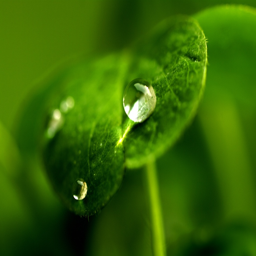

'dew'

In [14]:
image = PIL.Image.open(next(images_path.glob(class_names[0] + "/*"))).resize((image_size, image_size))
display(image)
class_names[0]

##### Creating the model using the Sequential API

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), input_shape=[image_size, image_size, 3], activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (5, 5), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

In [18]:
model.layers

In [19]:
hidden3 = model.layers[3]
hidden3.name

'conv2d_1'

In [20]:
model.get_layer("conv2d_1") is hidden3

True

In [21]:
weights, biases = hidden3.get_weights()

In [22]:
weights.shape

(5, 5, 32, 64)

In [23]:
biases.shape

(64,)

##### Compiling the model

In [24]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

##### Training and evaluating the model

In [25]:
history = model.fit(train_ds, epochs=1, validation_data=valid_ds) # TODO

161/161 [==============================] - 78s 477ms/step - loss: 2.3518 - accuracy: 0.2135 - val_loss: 2.1431 - val_accuracy: 0.2568


In [26]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 161}

In [27]:
len(history.epoch)

1

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

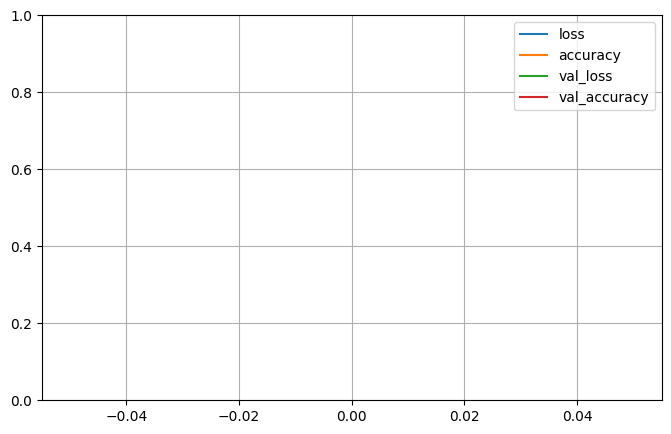

In [29]:
from matplotlib import pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [30]:
model.evaluate(test_ds)

22/22 [==============================] - 3s 110ms/step - loss: 2.1387 - accuracy: 0.2576


[2.138713836669922, 0.2575976848602295]

##### Using the model to make predictions

In [31]:
new = test_ds.take(1)
proba = model.predict(new, verbose=0)[:5]
proba.round(2)

array([[0.09, 0.1 , 0.09, 0.09, 0.09, 0.08, 0.09, 0.08, 0.1 , 0.1 , 0.09],
       [0.08, 0.04, 0.07, 0.08, 0.03, 0.04, 0.03, 0.1 , 0.26, 0.08, 0.19],
       [0.1 , 0.1 , 0.09, 0.09, 0.09, 0.08, 0.09, 0.08, 0.1 , 0.09, 0.09],
       [0.09, 0.1 , 0.09, 0.09, 0.09, 0.08, 0.09, 0.08, 0.1 , 0.1 , 0.09],
       [0.09, 0.08, 0.09, 0.09, 0.07, 0.08, 0.07, 0.09, 0.14, 0.09, 0.11]],
      dtype=float32)

In [32]:
y_pred = np.argmax(model.predict(new, verbose=0), axis=-1)[:5]
y_pred

array([8, 8, 8, 8, 8], dtype=int64)

In [33]:
np.array(class_names)[y_pred]

array(['rime', 'rime', 'rime', 'rime', 'rime'], dtype='<U9')

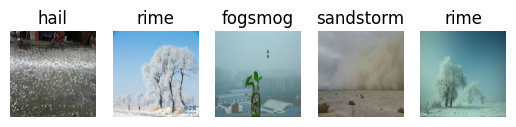

In [34]:
for x, y in new.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow((x[i].numpy()*255).astype("uint8"))
        plt.title(class_names[y.numpy()[i]])
        plt.axis("off")

#### Building a Regression MLP Using the Sequential API

In [35]:
diamonds_ds.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


In [36]:
diamonds_data, diamonds_target = diamonds_ds[["carat", "depth", "table", "x", "y", "z"]], diamonds_ds["price"]

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(diamonds_data, diamonds_target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [38]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam())
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
949/949 [==============================] - 1s 882us/step - loss: 30857490.0000 - val_loss: 28540108.0000
Epoch 2/20
949/949 [==============================] - 1s 889us/step - loss: 26131240.0000 - val_loss: 22148408.0000
Epoch 3/20
949/949 [==============================] - 1s 788us/step - loss: 18929134.0000 - val_loss: 14915965.0000
Epoch 4/20
949/949 [==============================] - 1s 876us/step - loss: 11957404.0000 - val_loss: 8911486.0000
Epoch 5/20
949/949 [==============================] - 1s 777us/step - loss: 6643918.0000 - val_loss: 5058276.0000
Epoch 6/20
949/949 [==============================] - 1s 857us/step - loss: 3657242.2500 - val_loss: 3547225.5000
Epoch 7/20
949/949 [==============================] - 1s 749us/step - loss: 2606336.2500 - val_loss: 3296410.2500
Epoch 8/20
949/949 [==============================] - 1s 797us/step - loss: 2376188.5000 - val_loss: 3251820.7500
Epoch 9/20
949/949 [==============================] - 1s 828us/step - loss: 22994

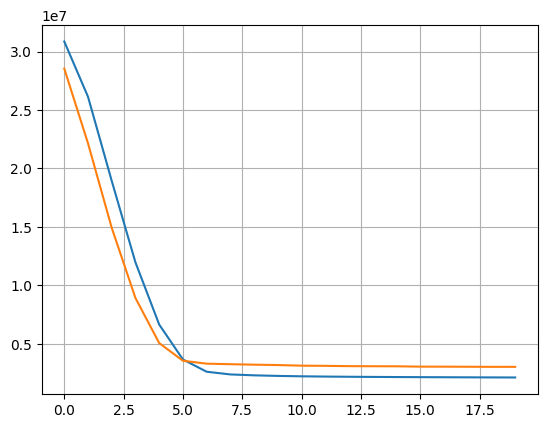

In [39]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.show()

In [40]:
model.evaluate(X_test, y_test)

422/422 [==============================] - 0s 532us/step - loss: 2172034.0000


2172034.0

In [41]:
X_new = X_test[:3]
y_pred = model.predict(X_new, verbose=0)
y_pred

array([[ 663.7852],
       [1408.3505],
       [1065.0315]], dtype=float32)

In [42]:
y_new = y_test[:3]
y_new

1388      559
50052    2201
41645    1238
Name: price, dtype: int64

In [43]:
---

SyntaxError: invalid syntax (1395312646.py, line 1)

#### Building Complex Models Using the Functional API

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid));

In [ ]:
model.evaluate((X_test_A, X_test_B), y_test)

In [ ]:
y_pred = model.predict((X_new_A, X_new_B), verbose=0)
y_pred

In [ ]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
          validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]));

In [ ]:
model.evaluate([X_test_A, X_test_B], [y_test, y_test]) # total_loss, main_loss, aux_loss

In [ ]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B), verbose=0)
y_pred_main, y_pred_aux

#### Using the Subclassing API to Build Dynamic Models

In [ ]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs, training=None, mask=None):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [ ]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=20, 
          validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)));

In [ ]:
model.evaluate((X_test_A, X_test_B), (y_test, y_test)) # total_loss, main_loss, aux_loss

In [ ]:
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B), verbose=0)
y_pred_main, y_pred_aux

#### Saving and Restoring a Model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid));

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_new, verbose=0)
y_pred

In [ ]:
model.save("temp_model.keras")
model = keras.models.load_model("temp_model.keras")

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_new, verbose=0)
y_pred

#### Using Callbacks

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("temp_model.keras", save_best_only=True)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb]);

In [ ]:
model = keras.models.load_model("temp_model.keras") # rollback to best model

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, early_stopping_cb]);

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("val/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
val_train_ratio_cb = PrintValTrainRatioCallback()

In [ ]:
model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid), 
          callbacks=[val_train_ratio_cb], verbose=2);

#### Using TensorBoard for Visualization

```tensorboard --logdir=lab9/logs --port=6006```

In [ ]:
def get_run_logdir():
    root_logdir = os.path.join(os.curdir, "logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), 
          callbacks=[checkpoint_cb, tensorboard_cb]);

## Fine-Tuning Neural Network Hyperparameters

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=None):
    if input_shape is None:
        input_shape = [8]
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=None,
                           callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid));

In [ ]:
keras_reg.score(X_test, y_test) # R^2 value

In [ ]:
y_pred = keras_reg.predict(X_new, verbose=0)
y_pred

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2)
}

keras_reg.verbose = 0
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid));

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_ # R^2 value

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test) # R^2 value

In [ ]:
rnd_search_cv.predict(X_new)